# Imports

In [598]:
import pandas as pd
import numpy as np

TODO:
group by labels (mood) and not hourly

# Feature Engineering

In [599]:
df = pd.read_csv('dataset_mood_smartphone.csv', index_col=0)
df['time'] = pd.to_datetime(df['time'])
df.head()

,id,time,variable,value
1,AS14.01,2014-02-26 13:00:00,mood,6.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0


In [600]:
#categorize data
categorical = ['call','sms', 'activity']
discrete = ['mood', 'circumplex.arousal', 'circumplex.valence']
cont = ['downtime', 'appCat.builtin', 'appCat.communication', 'appCat.entertainment', 'appCat.finance', 'appCat.game', 'appCat.office', 'appCat.other', 'appCat.social', 'appCat.travel', 'appCat.unknown', 'appCat.utilities', 'appCat.weather']

In [601]:
#calculate time deltas between entries (sorted by [id,time])
df.sort_values(['id','time'])
df['downtime'] = df['time']-df['time'].shift()
df.loc[df['downtime'].isna(), 'downtime'] = pd.Timedelta(0)
df['downtime'] /= pd.Timedelta(1, 's')

In [602]:
#adjust time delta if value is continous and value means event legth
df['downtime_adj'] = df[df['variable'].shift().isin(cont)]['downtime'] - df[df['variable'].isin(cont)]['value'].shift()
df.loc[df['downtime_adj'].isna(), 'downtime_adj'] = df[df['downtime_adj'].isna()]['downtime']
df['downtime'] = df['downtime_adj']
df.drop(columns='downtime_adj', inplace=True)
df.tail(10)

,id,time,variable,value,downtime
2769196,AS14.30,2014-04-06 11:24:23.055,appCat.weather,41.881,1537.098
2769197,AS14.30,2014-04-06 11:38:32.033,appCat.weather,4.117,807.097
2769509,AS14.30,2014-04-07 18:13:31.111,appCat.weather,11.039,110094.961
2769513,AS14.30,2014-04-07 18:16:49.107,appCat.weather,60.829,186.957
2769514,AS14.30,2014-04-07 18:21:04.197,appCat.weather,3.018,194.261
2770399,AS14.30,2014-04-11 07:51:16.948,appCat.weather,8.032,307809.733
2772465,AS14.30,2014-04-19 11:00:32.747,appCat.weather,3.008,702547.767
2774026,AS14.30,2014-04-26 10:19:07.434,appCat.weather,7.026,602311.679
2774133,AS14.30,2014-04-27 00:44:48.450,appCat.weather,23.033,51933.990
2784435,AS14.32,2014-04-07 18:25:14.036,appCat.weather,22.431,-1664397.447


In [603]:
#time delta over 1 day set to 0 and negative delta also set to zero
df.loc[df['downtime'] > 86400, 'downtime'] = 0
df.loc[df['downtime'] < 0, 'downtime'] = 0
df.head()

,id,time,variable,value,downtime
1,AS14.01,2014-02-26 13:00:00,mood,6.0,0.0
2,AS14.01,2014-02-26 15:00:00,mood,6.0,7200.0
3,AS14.01,2014-02-26 18:00:00,mood,6.0,10800.0
4,AS14.01,2014-02-26 21:00:00,mood,7.0,10800.0
5,AS14.01,2014-02-27 09:00:00,mood,6.0,43200.0


In [604]:
#data cleaning, removing rows with 0 time delta
downtime = df.drop(columns=['value', 'variable'])
downtime['variable'] = 'downtime'
downtime = downtime.rename(columns={'downtime': 'value'})
downtime.drop(downtime.loc[downtime['value'] == 0].index, inplace=True)
df.drop(columns='downtime', inplace=True)

In [605]:
downtime

,id,time,value,variable
2,AS14.01,2014-02-26 15:00:00.000,7200.000,downtime
3,AS14.01,2014-02-26 18:00:00.000,10800.000,downtime
4,AS14.01,2014-02-26 21:00:00.000,10800.000,downtime
5,AS14.01,2014-02-27 09:00:00.000,43200.000,downtime
6,AS14.01,2014-02-27 12:00:00.000,10800.000,downtime
...,...,...,...,...
2769196,AS14.30,2014-04-06 11:24:23.055,1537.098,downtime
2769197,AS14.30,2014-04-06 11:38:32.033,807.097,downtime
2769513,AS14.30,2014-04-07 18:16:49.107,186.957,downtime
2769514,AS14.30,2014-04-07 18:21:04.197,194.261,downtime


In [606]:
df = pd.concat([df,downtime]).sort_values(['id', 'time'])

In [607]:
df['time'] = df['time'].dt.floor('H')

maybe instead of flooring time use only timestamps of mood so that we have labels and aggregate data between entries for mood

In [608]:
#df['hour'] = df['time'].dt.hour
#df['day'] = df['time'].dt.day
#df['month'] = df['time'].dt.month

In [609]:
#aggregate different categories of values
df2 = df[df['variable'].isin(discrete)].groupby(['id', 'time', 'variable']).mean() #calculate mean for discrete values 
df3 = df[df['variable'].isin(cont)].groupby(['id', 'time', 'variable']).sum() #sum for continous data
df4 = df[df['variable'].isin(categorical)].groupby(['id', 'time', 'variable']).max() #max for categorical

In [610]:
df = pd.concat([df2,df3,df4])
df.sort_index(inplace=True)

In [611]:
df.head(10)

value
id      time                variable           
AS14.01 2014-02-17 12:00:00 call          1.000
        2014-02-17 18:00:00 call          1.000
                            downtime  23023.126
        2014-02-18 09:00:00 call          1.000
                            downtime  54085.737
        2014-02-19 14:00:00 call          1.000
        2014-02-19 17:00:00 call          1.000
                            downtime  10831.019
                            sms           1.000
        2014-02-19 18:00:00 call          1.000

In [612]:
df.unstack().fillna(0).head(50)

value                                      \
variable                    activity appCat.builtin appCat.communication   
id      time                                                               
AS14.01 2014-02-17 12:00:00      0.0            0.0                  0.0   
        2014-02-17 18:00:00      0.0            0.0                  0.0   
        2014-02-18 09:00:00      0.0            0.0                  0.0   
        2014-02-19 14:00:00      0.0            0.0                  0.0   
        2014-02-19 17:00:00      0.0            0.0                  0.0   
        2014-02-19 18:00:00      0.0            0.0                  0.0   
        2014-02-19 21:00:00      0.0            0.0                  0.0   
        2014-02-20 10:00:00      0.0            0.0                  0.0   
        2014-02-20 11:00:00      0.0            0.0                  0.0   
        2014-02-20 13:00:00      0.0            0.0                  0.0   
        2014-02-21 15:00:00      0.0            0.0                  0.0   
        2014-02-22 17:00:00      0.0            0.0                  0.0   
        2014-02-22 18:00:00      0.0            0.0                  0.0   
        2014-02-22 22:00:00      0.0            0.0                  0.0   
        2014-02-25 11:00:00      0.0            0.0                  0.0   
        2014-02-25 12:00:00      0.0            0.0                  0.0   
        2014-02-26 13:00:00      0.0            0.0                  0.0   
        2014-02-26 15:00:00      0.0            0.0                  0.0   
        2014-02-26 16:00:00      0.0            0.0                  0.0   
        2014-02-26 18:00:00      0.0            0.0                  0.0   
        2014-02-26 21:00:00      0.0            0.0                  0.0   
        2014-02-27 09:00:00      0.0            0.0                  0.0   
        2014-02-27 12:00:00      0.0            0.0                  0.0   
        2014-02-27 15:00:00      0.0            0.0                  0.0   
        2014-02-28 20:00:00      0.0            0.0                  0.0   
        2014-02-28 22:00:00      0.0            0.0                  0.0   
        2014-03-01 09:00:00      0.0            0.0                  0.0   
        2014-03-03 20:00:00      0.0            0.0                  0.0   
        2014-03-05 21:00:00      0.0            0.0                  0.0   
        2014-03-06 20:00:00      0.0            0.0                  0.0   
        2014-03-07 14:00:00      0.0            0.0                  0.0   
        2014-03-07 15:00:00      0.0            0.0                  0.0   
        2014-03-07 17:00:00      0.0            0.0                  0.0   
        2014-03-10 15:00:00      0.0            0.0                  0.0   
        2014-03-11 14:00:00      0.0            0.0                  0.0   
        2014-03-12 12:00:00      0.0            0.0                  0.0   
        2014-03-12 13:00:00      0.0            0.0                  0.0   
        2014-03-12 14:00:00      0.0            0.0                  0.0   
        2014-03-12 18:00:00      0.0            0.0                  0.0   
        2014-03-13 09:00:00      0.0            0.0                  0.0   
        2014-03-13 18:00:00      0.0            0.0                  0.0   
        2014-03-14 10:00:00      0.0            0.0                  0.0   
        2014-03-14 17:00:00      0.0            0.0                  0.0   
        2014-03-15 19:00:00      0.0            0.0                  0.0   
        2014-03-16 17:00:00      0.0            0.0                  0.0   
        2014-03-17 13:00:00      0.0            0.0                  0.0   
        2014-03-18 10:00:00      0.0            0.0                  0.0   
        2014-03-18 11:00:00      0.0            0.0                  0.0   
        2014-03-18 16:00:00      0.0            0.0                  0.0   
        2014-03-19 10:00:00      0.0            0.0                  0.0   

  

In [613]:
df.loc[pd.IndexSlice['AS14.01', :, 'mood']].head(10)

value
id      time                variable       
AS14.01 2014-02-26 13:00:00 mood        6.0
        2014-02-26 15:00:00 mood        6.0
        2014-02-26 18:00:00 mood        6.0
        2014-02-26 21:00:00 mood        7.0
        2014-02-27 09:00:00 mood        6.0
        2014-02-27 12:00:00 mood        6.0
        2014-02-27 15:00:00 mood        7.0
        2014-03-21 09:00:00 mood        6.0
        2014-03-21 11:00:00 mood        6.0
        2014-03-21 15:00:00 mood        7.0

<AxesSubplot:xlabel='time'>

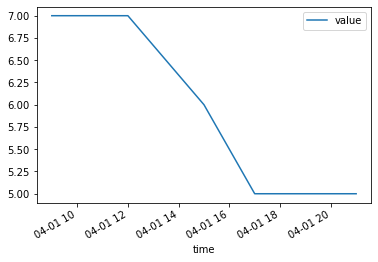

In [614]:
#mood change during day quite large
df.loc[pd.IndexSlice['AS14.01', '2014-04-01',:]].loc[pd.IndexSlice[:,:,'mood']].droplevel('id').plot()